# Машинное обучение

## Практическое задание 3. Классификация

### Общая информация
Дата выдачи: 02.12.2024

Жесткий дедлайн: 08.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----


### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: As we use predict_proba -  it's the probabilieties generated.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


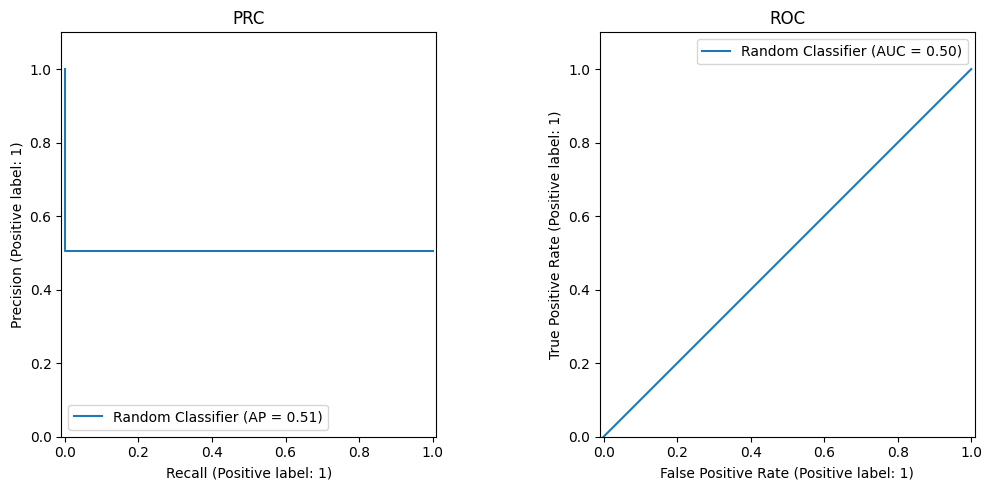

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
len(X_train)

7000

In [8]:
from sklearn.svm import LinearSVC

parameters = {'C': np.linspace(0.1, 3, 20)} # typical grid 

svc = LinearSVC() # function
grid_s = GridSearchCV(svc, parameters, cv=7, verbose=1, scoring='average_precision')
# cv=7 - number of cross-validation blocks - 1000 obs. in each shiukd be enough
# verbose>1 - for more output info
# scoring='average_precision' - correct scoring metrics (in the context of AUC-PR - we need a precition metric)
grid_s.fit(X_train, y_train)

Fitting 7 folds for each of 20 candidates, totalling 140 fits


GridSearchCV(cv=7, estimator=LinearSVC(),
             param_grid={'C': array([0.1       , 0.25263158, 0.40526316, 0.55789474, 0.71052632,
       0.86315789, 1.01578947, 1.16842105, 1.32105263, 1.47368421,
       1.62631579, 1.77894737, 1.93157895, 2.08421053, 2.23684211,
       2.38947368, 2.54210526, 2.69473684, 2.84736842, 3.        ])},
             scoring='average_precision', verbose=1)

In [9]:
best_C = grid_s.best_params_['C']
print(f'Optimal C: {round(best_C, 3)}')

Optimal C: 2.542


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

LinearSVC Classifier metrics
AUC-PR: 0.8290
AUC-ROC: 0.8480


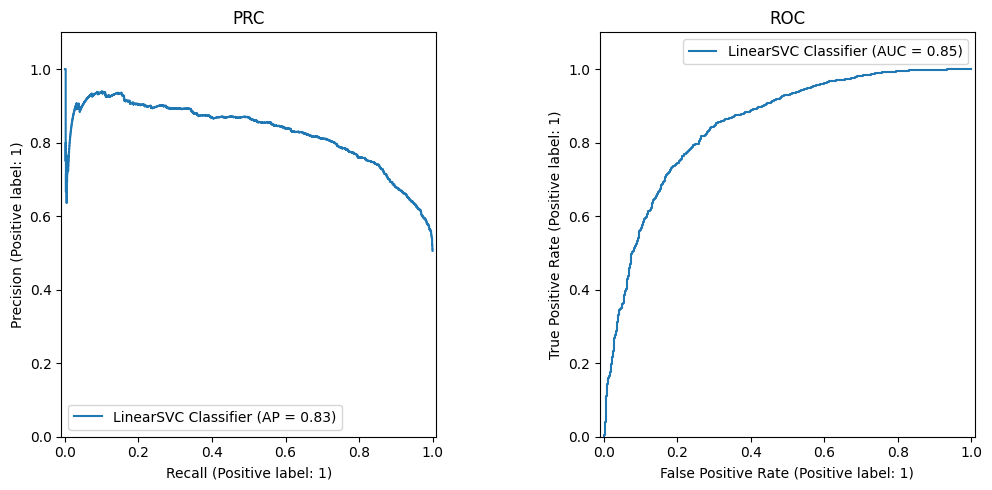

In [10]:
svc_best_C = LinearSVC(C=best_C)
svc_best_C.fit(X_train, y_train)
y_scores = svc_best_C.decision_function(X_test)

depict_pr_roc(y_test, y_scores, 'LinearSVC Classifier')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали? 
  ROC Curve (Receiver Operating Characteristic): Shortly, TP down, FN up =>TPR dowm; FP down, TN up =>  FRP down
  The PR curve (Precision-Recall) is based on Precision and Recall and is especially helpful for evaluating models in imbalanced datasets (note). Thereshold decreases => TP down, FP down => Precision  up; while TP down, FN up => recall up.
- Монотонные ли кривые? Как вы это объясните?
  The ROC curve is typically monotonically increasing.As the classification threshold decreases, the True Positive Rate (TPR) and False Positive Rate (FPR) both increase, thus - never goes down.
  The Precision-Recall (PR) curve is generally monotonic with respect to recall. As the threshold decreases, recall always increases because more samples are classified as positive, which captures more true positives, while , precision may either increase or decrease, depending on how many false positives are also being classified as positive. Also note that FN only decreases with threshold (thus keeping recall monotonic). As could happen, due to some anomalies at with the very low threshold values (possibly - many false positives).

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [11]:
# well, no need for code, really. BUt okay
df_metrics.loc['SVR'] = [
      average_precision_score(y_test, y_scores),
      roc_auc_score(y_test, y_scores),
      0,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
SVR,0.829014,0.847971,0.0


Well, as expected-  SVC does much better than the famous cion flip. 

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [12]:
from sklearn.linear_model import LogisticRegression

parameters = {'C': np.linspace(0.1, 3, 20)} # typical grid 

logist = LogisticRegression() # function
logist = GridSearchCV(logist, parameters, cv=7, verbose=1, scoring='average_precision')
# cv=7 - number of cross-validation blocks - 1000 obs. in each shiukd be enough
# verbose>1 - for more output info
# scoring='average_precision' - correct scoring metrics (in the context of AUC-PR - we need a precition metric)
logist.fit(X_train, y_train)

Fitting 7 folds for each of 20 candidates, totalling 140 fits


GridSearchCV(cv=7, estimator=LogisticRegression(),
             param_grid={'C': array([0.1       , 0.25263158, 0.40526316, 0.55789474, 0.71052632,
       0.86315789, 1.01578947, 1.16842105, 1.32105263, 1.47368421,
       1.62631579, 1.77894737, 1.93157895, 2.08421053, 2.23684211,
       2.38947368, 2.54210526, 2.69473684, 2.84736842, 3.        ])},
             scoring='average_precision', verbose=1)

In [13]:
best_C_log = logist.best_params_['C']
print(f'Optimal C: {round(best_C_log, 3)}')

Optimal C: 0.1


Logistic Regression Classifier metrics
AUC-PR: 0.8294
AUC-ROC: 0.8478


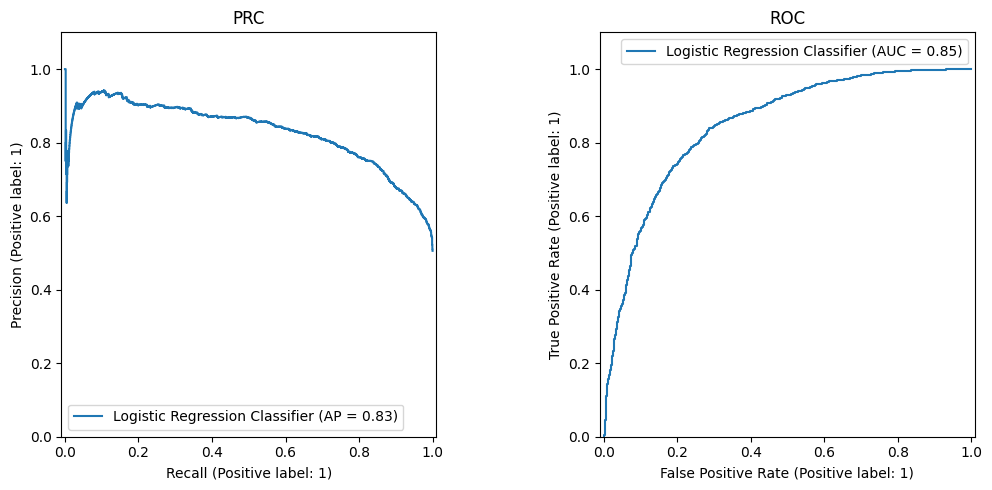

In [14]:
logist_best_C = LogisticRegression(C=best_C_log)
logist_best_C.fit(X_train, y_train)
y_scores_log = logist_best_C.decision_function(X_test)

depict_pr_roc(y_test, y_scores_log, 'Logistic Regression Classifier')

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
LinearSVC Classifier metrics
AUC-PR: 0.8290
AUC-ROC: 0.8480
Logistic Regression Classifier metrics
AUC-PR: 0.8294
AUC-ROC: 0.8478


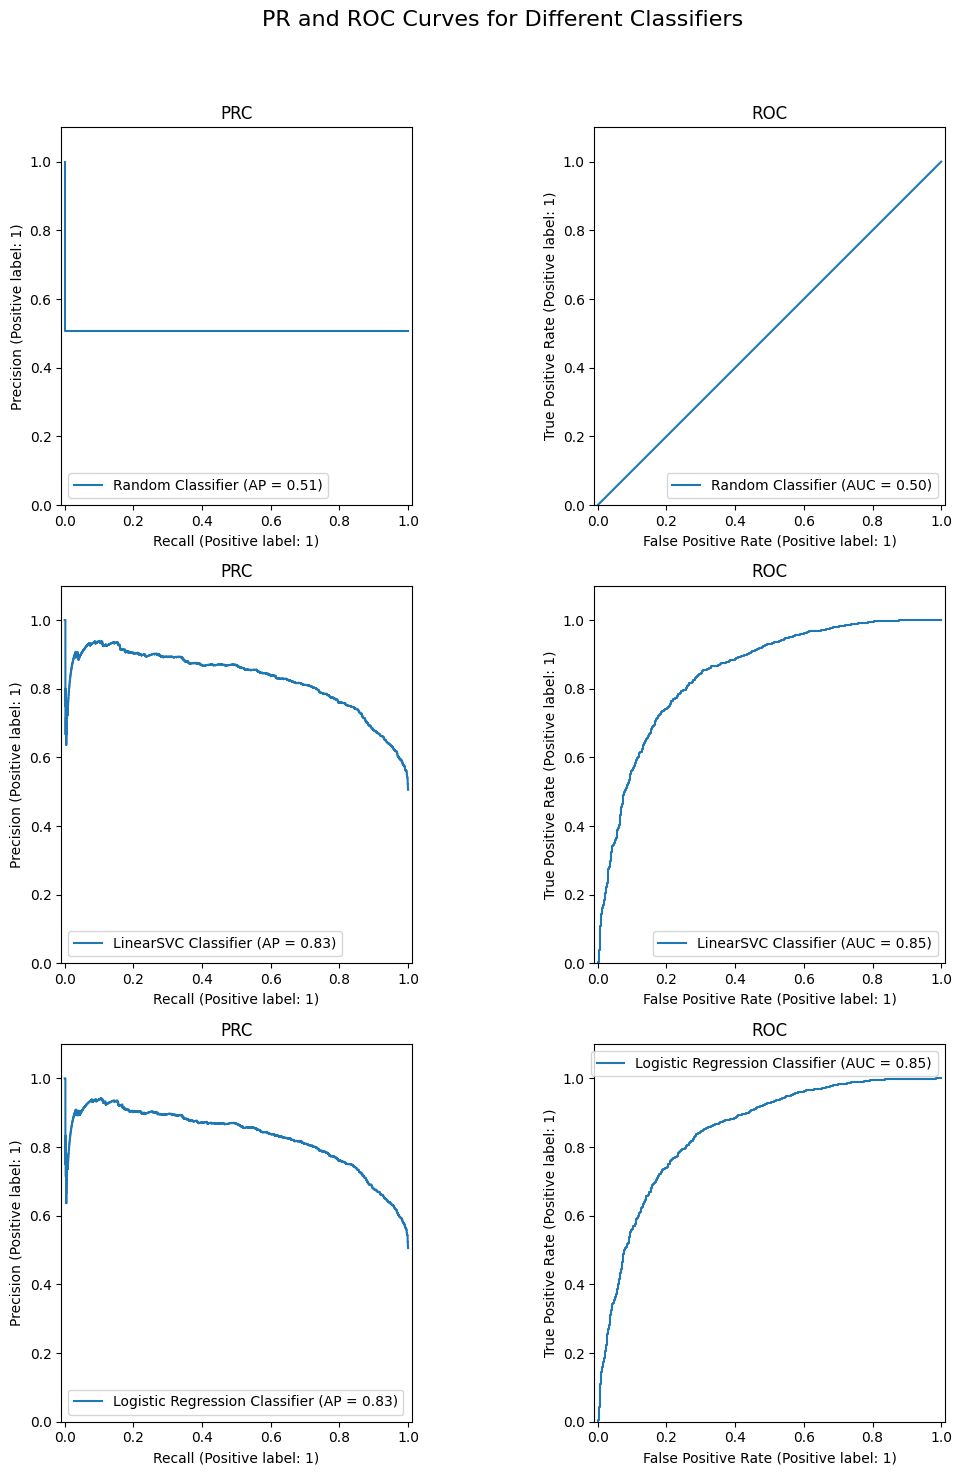

In [15]:
# Create a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('PR and ROC Curves for Different Classifiers', fontsize=16)

axes = axes.flatten()

# Random Classifier
depict_pr_roc(y_test, y_random, 'Random Classifier', ax=[axes[0], axes[1]])

# LinearSVC Classifier
depict_pr_roc(y_test, y_scores, 'LinearSVC Classifier', ax=[axes[2], axes[3]])

# Logistic Regression Classifier
depict_pr_roc(y_test, y_scores_log, 'Logistic Regression Classifier', ax=[axes[4], axes[5]])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



In [16]:
df_metrics.loc['Logistic'] = [
      average_precision_score(y_test, y_scores_log),
      roc_auc_score(y_test, y_scores_log),
      0,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
SVR,0.829014,0.847971,0.0
Logistic,0.829437,0.847846,0.0


**Ответ:** Well, they are pretty much the same, judged by the graphs and areas under the curves (up to 4th digit after digit point). If we really want to compare after 4th digit than Logistic regeression is better than SVC. Why? Complecated question, google says:  Probabilistic Output, Linearly Separable Data, SVC, especially with a linear kernel, can be very sensitive to outliers ....

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [17]:
X, y = make_classification(
    n_samples=10000,       # Number of samples
    n_features=2,          # Number of features
    n_informative=2,       # Make both features informative (linearealy independent - new info)
    n_redundant=0,         # No redundant features (linearly dependent - no new info)
    random_state=42        # Setting random state for reproducibility
)

In [18]:
# repeated code
parameters = {'C': np.linspace(0.1, 3, 20)} # typical grid 

# seems like LinearSVC doesn't work here - doesn't work with pprobabilities. Insteas, use SVC with linear Karnel (because Google says so)

svc = LinearSVC() # function
grid_s2 = GridSearchCV(svc, parameters, cv=5, verbose=0, scoring='average_precision')
grid_s2.fit(X, y)
best_C2 = grid_s2.best_params_['C']

# new code
svc_best_C2 = SVC(C=best_C2, kernel='linear', probability=True)  # Using SVC with the best C
svc_best_C2.fit(X, y)

# Predict probabilities using the fitted model
y_pred2 = svc_best_C2.predict_proba(X)

# Get the support vectors from the model
sup_vectors = svc_best_C2.support_vectors_

print(sup_vectors)

[[ 1.32636145  0.3205542 ]
 [ 1.057275   -0.15324615]
 [-1.0939189   0.97216893]
 ...
 [-0.38816539 -0.3181144 ]
 [-0.46887825  0.34041696]
 [ 1.04275178 -1.33012838]]


There are the coordinates of our support vectors.

"Support vectors are the crucial data points that define the SVM decision boundary." - with this knowledge let's build a graph.

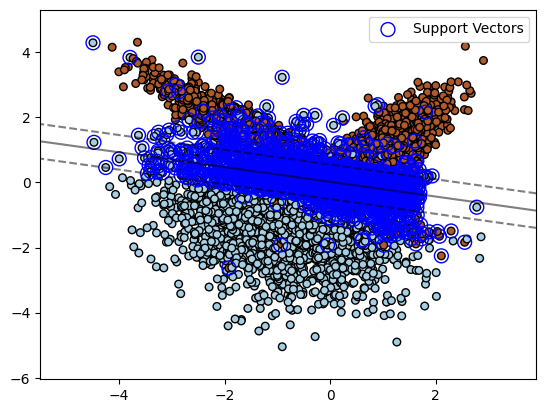

In [19]:
# yep, I modified a code a bit (also had to change the coordinates display - Stack helped. At least now there is a graph)
def plot_svm_2D(X, y, model, plot_support=True):
    # Create a grid for visualization
    xx = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 30)
    yy = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Get the decision function for each point in the grid
    Z = model.decision_function(xy).reshape(XX.shape)

    # Plot the decision boundary and margins
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Plot the data points
    plt.scatter(
        X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired, edgecolors='k'
    )

    # Plot the support vectors
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0], model.support_vectors_[:, 1],
            s=100, linewidth=1, edgecolor="blue", facecolors='none', label='Support Vectors'
        )

    plt.legend()
    plt.show()

# Assuming 'svc_best_C2' is already trained, and X, y are available
plot_svm_2D(X, y, svc_best_C2)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Which are close enough to they separating line. Actually, the separating hyperplane in constructed upon these point- they are intermediate points, for which the model is not so sure to which class they belong. Thus, they should be the border; SVM tries to find a hyperplane that maximizes the margin (distance) between its support vectors (they are just 2D in our case, but they could be N dimensional, actually).

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

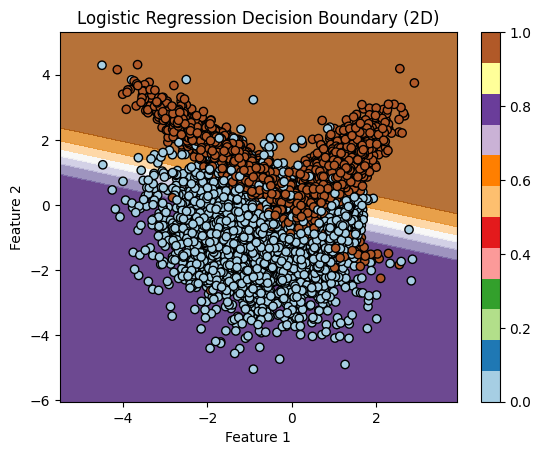

In [20]:
# Set up Logistic Regression model with GridSearchCV to find the best parameter C
parameters = {'C': np.linspace(0.1, 3, 20)}
logistic_model = LogisticRegression()

# Perform grid search to find the best value of C
grid_search = GridSearchCV(logistic_model, parameters, cv=5, verbose=0, scoring='average_precision')
grid_search.fit(X, y)
best_C_log_2d = grid_search.best_params_['C']

# Train the best Logistic Regression model
best_logistic_model_2d = LogisticRegression(C=best_C_log_2d)
best_logistic_model_2d.fit(X, y)

def plot_logreg_2D(X, y, model):
    # grid 
    xx = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    yy = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Get predicted probabilities
    Z = model.predict_proba(xy)[:, 1]  # Use predicted probabilities for class 1
    Z = Z.reshape(XX.shape)

    # Plot the decision boundary
    plt.contourf(XX, YY, Z, alpha=0.8, cmap=plt.cm.PuOr_r)

    # Plot the original data points
    plt.scatter(
        X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired
    )

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Logistic Regression Decision Boundary (2D)')
    plt.colorbar()
    plt.show()

plot_logreg_2D(X, y, best_logistic_model_2d)

In [21]:
# repeated code
parameters = {'C': np.linspace(0.1, 3, 20)}

logist_2 = LogisticRegression() # function
logist_2 = GridSearchCV(logist_2, parameters, cv=5, verbose=0, scoring='average_precision')
logist_2.fit(X, y)
best_C_log_2 = logist_2.best_params_['C']

best_C_log_model = LogisticRegression(C=best_C_log_2)
best_C_log_model.fit(X_train, y_train)

LogisticRegression(C=3.0)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Well, it has classes of mixed object; obviously, model isn't sure about the classes of the object there and almost randomly assign them  (prob = 0.5).

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

- bin_middle_points.append((l - r) / 2):
  
   the middle point of the interval should be calculated as  the average of the left and right boundaries => bin_middle_points.append((l + r) / 2)
- bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1)):
  
   np.min() on the boolean comparison will only tell if there are any positives (if all values are True or not), not the actual fraction => use np.mean() to calculate the fraction of positive samples within the bin

In [22]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i # left boundary
        r = 1.0 / n_bins * (i + 1) # right boundary
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [23]:
# data generation
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# repeated code
## SVC
parameters = {'C': np.linspace(0.1, 3, 20)}

svc = LinearSVC()
grid_s3 = GridSearchCV(svc, parameters, cv=5, verbose=0, scoring='average_precision')
grid_s3.fit(X_train, y_train)
best_C3 = grid_s3 .best_params_['C']
svc_best_C3 = SVC(C=best_C3, kernel='linear', probability=True)
svc_best_C3.fit(X_train, y_train)

# Predict probabilities using the fitted model
y_pred_svc = svc_best_C3.predict_proba(X_test)

## Logistic Reg
logist = LogisticRegression() # function
logist_3 = GridSearchCV(logist, parameters, cv=5, verbose=0, scoring='average_precision')
logist_3.fit(X_train, y_train)

best_C_log_3 = logist_3.best_params_['C']
logist_best_C_3 = LogisticRegression(C=best_C_log_3)
logist_best_C_3.fit(X_train, y_train)

# Predict probabilities using the fitted model
y_pred_log = logist_best_C_3.predict_proba(X_test)

<Figure size 800x800 with 0 Axes>

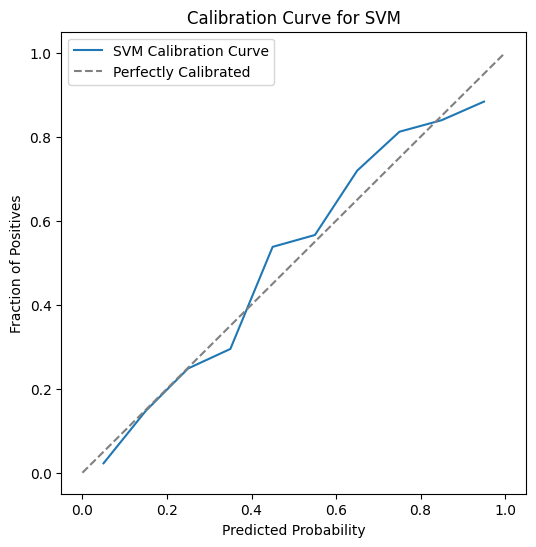

In [25]:
# SVM + Calibration Curve
plt.figure(figsize=(8, 8))
plot_calibration_curve(y_test, y_pred_svc[:, 1]) 
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.ylim([-0.05, 1.05])
plt.grid()
plt.legend(['SVM Calibration Curve', 'Perfectly Calibrated']) 
plt.title("Calibration Curve for SVM")
plt.show()

<Figure size 800x800 with 0 Axes>

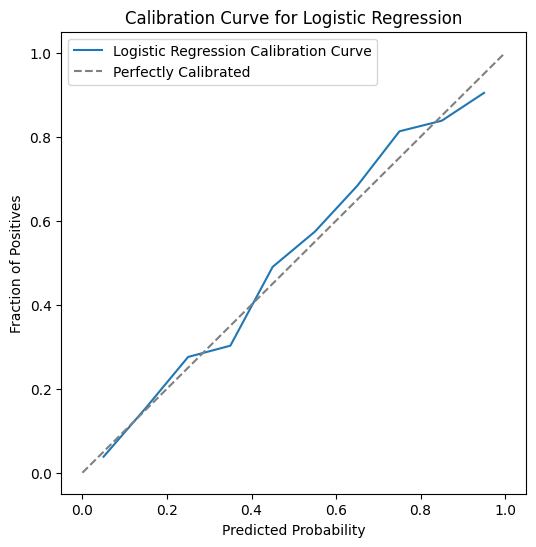

In [26]:
# CLogistic Regression + Calibration Curve
plt.figure(figsize=(8, 8))
plot_calibration_curve(y_test, y_pred_log[:, 1])
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated') 
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.ylim([-0.05, 1.05])
plt.grid()
plt.legend(['Logistic Regression Calibration Curve', 'Perfectly Calibrated']) 
plt.title("Calibration Curve for Logistic Regression")
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Well, once` again, results look pretty much the same. I would say that there is a pretty solid calibration - the predicted probabilities are really close to the perfet calibration. Or just prefitted hyper-parameters makes magic ))

Thus, I decided to do the same but without hyper-parameter C preliminary fitting + LinearSVC().

In [27]:
svc = LinearSVC()
svc.fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

logist_4 = LogisticRegression()
logist_4.fit(X_train, y_train)
y_pred_log_4 = logist_4.predict_proba(X_test)

<Figure size 800x800 with 0 Axes>

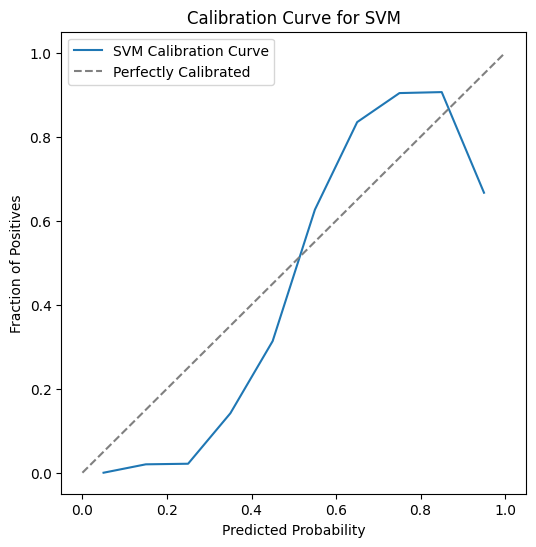

In [28]:
# SVM + Calibration Curve
plt.figure(figsize=(8, 8))
plot_calibration_curve(y_test, svc_pred) 
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.ylim([-0.05, 1.05])
plt.grid()
plt.legend(['SVM Calibration Curve', 'Perfectly Calibrated']) 
plt.title("Calibration Curve for SVM")
plt.show()

<Figure size 800x800 with 0 Axes>

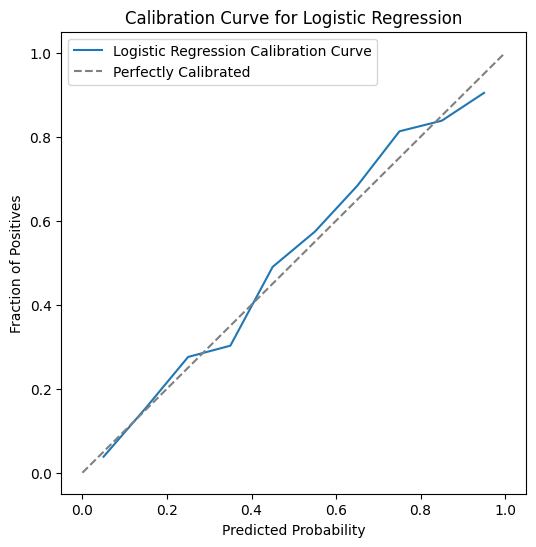

In [29]:
# CLogistic Regression + Calibration Curve
plt.figure(figsize=(8, 8))
plot_calibration_curve(y_test, y_pred_log[:, 1])
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated') 
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.ylim([-0.05, 1.05])
plt.grid()
plt.legend(['Logistic Regression Calibration Curve', 'Perfectly Calibrated']) 
plt.title("Calibration Curve for Logistic Regression")
plt.show()

They finally differ! SVM has a really bad calibration.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [30]:
from sklearn.metrics import log_loss, brier_score_loss

# Calculate LogLoss
log_loss_svm = log_loss(y_test, svc_pred)
log_loss_logreg = log_loss(y_test, y_pred_log[:, 1])

# Calculate Brier Score
brier_score_svm = brier_score_loss(y_test, svc_pred)
brier_score_logreg = brier_score_loss(y_test, y_pred_log[:, 1])

print("### Comparison of LogLoss and Brier Score ###\n")
print(f"LogLoss for SVM:                {log_loss_svm:.4f}")
print(f"LogLoss for Logistic Regression: {log_loss_logreg:.4f}")

print(f'\nBrier Score for SVM:                {brier_score_svm:.4f}')
print(f"Brier Score for Logistic Regression: {brier_score_logreg:.4f}")


### Comparison of LogLoss and Brier Score ###

LogLoss for SVM:                0.5546
LogLoss for Logistic Regression: 0.4859

Brier Score for SVM:                0.1845
Brier Score for Logistic Regression: 0.1586


Well, SVM is worse than LR by all metrics.

Изучите распределение ответов классификаторов при помощи гистограмм

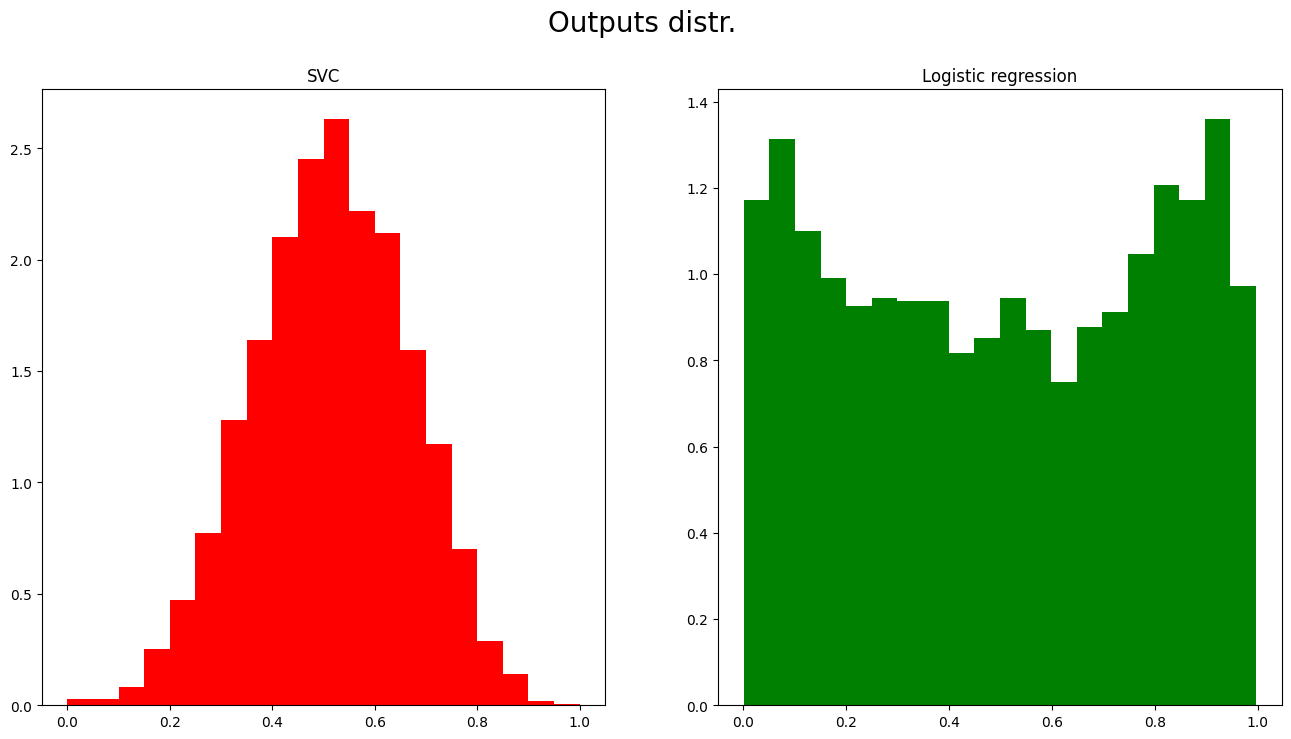

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].hist(svc_pred, bins=20, color='red', density='True')
axs[1].hist(y_pred_log[:, 1], bins=20, color='green', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distr.', size=20)
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Well, SVM is less sure about classification, thus, it gives many probabilities of class 1 around 0.5, while LR is more sure - thick tails.

Well, as we know from lectures, SVM is gooad at its job (creating a separating hyperplane), but without Platt scaling it's having problems with probabilities, unlike LR, which is working with them from the beginning.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [32]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_svc = CalibratedClassifierCV(estimator=svc, method='sigmoid', cv='prefit')
calibrated_svc.fit(X_train, y_train)

svc_pred_probs = calibrated_svc.predict_proba(X_test)

<Figure size 800x800 with 0 Axes>

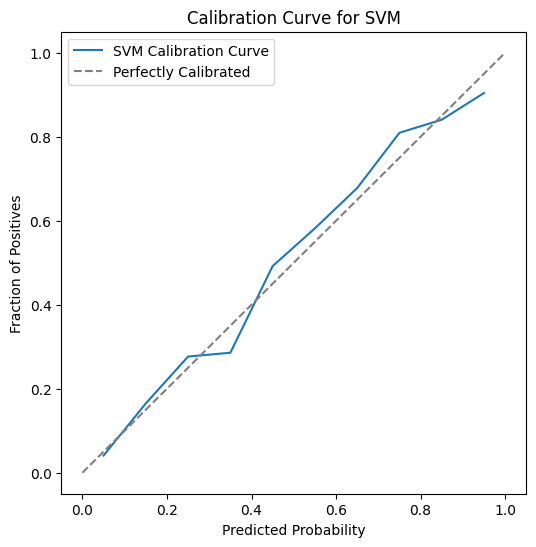

In [33]:
# SVM + Calibration Curve
plt.figure(figsize=(8, 8))
plot_calibration_curve(y_test, svc_pred_probs[:,1]) 
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.ylim([-0.05, 1.05])
plt.grid()
plt.legend(['SVM Calibration Curve', 'Perfectly Calibrated']) 
plt.title("Calibration Curve for SVM")
plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** From the looks of it, it did indeed.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [34]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Train SVM (without built-in probability calibration)
svm = SVC(kernel='linear', probability=False, random_state=42)
svm.fit(X_train, y_train)

# Step 2: Decision scores for calibration
dec_scores = svm.decision_function(X_test)

# Step 3: Normalize decision scores to [0, 1]
scaler = MinMaxScaler()
probs_uncalibrated = scaler.fit_transform(dec_scores.reshape(-1, 1)).flatten()

# Step 3: Fit Logistic Regression for calibration (Platt Scaling)
log_reg = LogisticRegression(random_state=42)
log_reg.fit(dec_scores.reshape(-1, 1), y_test)

# Step 6: Get calibrated probabilities
probs_calibrated = log_reg.predict_proba(dec_scores.reshape(-1, 1))[:, 1]

# Step 7: Compare
brier_uncalibrated = brier_score_loss(y_test, probs_uncalibrated)
brier_calibrated = brier_score_loss(y_test, probs_calibrated)

print(f"Brier Score Uncalibrated: {brier_uncalibrated:.4f}")
print(f"Brier Score Calibrated: {brier_calibrated:.4f}")


Brier Score Uncalibrated: 0.1848
Brier Score Calibrated: 0.1579


As we see, Platt  calibration works

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [35]:
# pip install kaggle

In [36]:
# import kagglehub

# path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

# # still doesn't work

In [37]:
# Прочитаем датасет
df_2 = pd.read_csv('C:/Users/Popov/Documents/Studies/NES_studies/Python/Machine_Learning/HA/HA_3/bike_buyers_clean.csv')
print(df_2.head())
print(df_2.info())

      ID Marital Status  Gender  Income  Children        Education  \
0  12496        Married  Female   40000         1        Bachelors   
1  24107        Married    Male   30000         3  Partial College   
2  14177        Married    Male   80000         5  Partial College   
3  24381         Single    Male   70000         0        Bachelors   
4  25597         Single    Male   30000         0        Bachelors   

       Occupation Home Owner  Cars Commute Distance   Region  Age  \
0  Skilled Manual        Yes     0        0-1 Miles   Europe   42   
1        Clerical        Yes     1        0-1 Miles   Europe   43   
2    Professional         No     2        2-5 Miles   Europe   60   
3    Professional        Yes     1       5-10 Miles  Pacific   41   
4        Clerical         No     0        0-1 Miles   Europe   36   

  Purchased Bike  
0             No  
1             No  
2             No  
3            Yes  
4            Yes  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

In [38]:
# Заменим пропуски категориальных переменных
# also let's change the tyoe of our y:
df_2['Purchased Bike'] = df_2['Purchased Bike'].map({'Yes': 1, 'No': -1})

categorical_columns = df_2.select_dtypes(include=['object']).columns
# include=['object'] - includes all cloumns with object types values

for col in categorical_columns:
    df_2[col] = df_2[col].fillna('undefined')

# Verify the replacement
print(df_2[categorical_columns].isnull().sum()) # 0 NANs in each column 

Marital Status      0
Gender              0
Education           0
Occupation          0
Home Owner          0
Commute Distance    0
Region              0
dtype: int64


In [39]:
# Отделим X и y
y = df_2['Purchased Bike']
X = df_2.drop(columns=['Purchased Bike'])

# Разделим на категориальные признаки и числовые
X_numerical = X.select_dtypes(include=['int'])
X_categorical = X.select_dtypes(include=['object'])

print(X_numerical.info())
print(X_categorical.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ID        1000 non-null   int64
 1   Income    1000 non-null   int64
 2   Children  1000 non-null   int64
 3   Cars      1000 non-null   int64
 4   Age       1000 non-null   int64
dtypes: int64(5)
memory usage: 39.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Marital Status    1000 non-null   object
 1   Gender            1000 non-null   object
 2   Education         1000 non-null   object
 3   Occupation        1000 non-null   object
 4   Home Owner        1000 non-null   object
 5   Commute Distance  1000 non-null   object
 6   Region            1000 non-null   object
dtypes: object(7)
memory usage: 54.8+ KB
None


В начале поработаем только с категориальными признаками

In [40]:
from sklearn.model_selection import train_test_split
# why not 666?) 
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

_How OrdinalEncoder Works (note)_

_It identifies all unique categories in each column of the input data.
Creates a mapping of each category to an integer starting from 0._

In [41]:
# your code here
from sklearn.preprocessing import OrdinalEncoder

# Initialize the encoder
encoder = OrdinalEncoder()

# time measuring
import time

# Initialize the timer
cumulative_time = 0
start_time = time.time()

# Encode
X_train_OE = encoder.fit_transform(X_train)
X_test_OE = encoder.fit_transform(X_test)

cumulative_time += time.time() - start_time

In [42]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(750, 7)
(250, 7)
(750,)
(250,)


Optimal C: 2.237
Logistic Regression Classifier metrics
AUC-PR: 0.5949
AUC-ROC: 0.6008
Total time: 0.3778 seconds


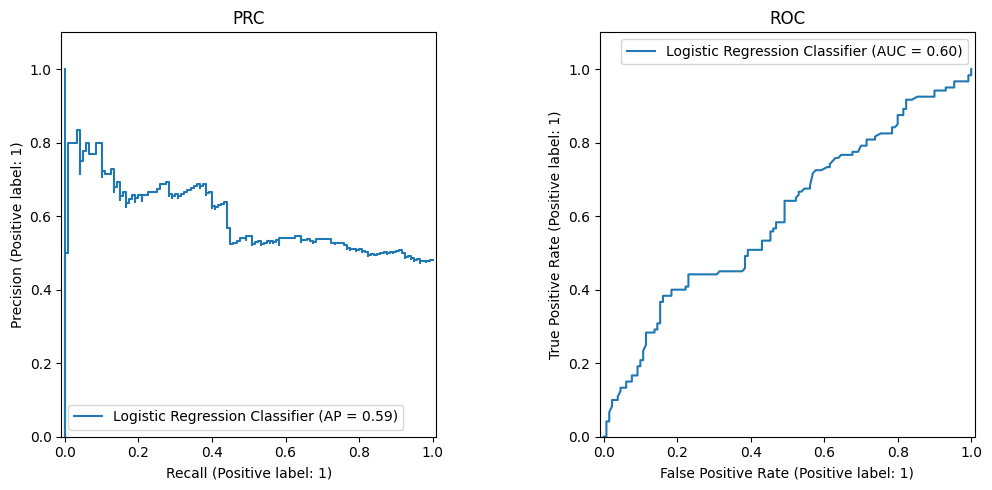

In [43]:
start_time = time.time()
parameters = {'C': np.linspace(0.1, 3, 20)} # typical grid 

logist = LogisticRegression() # function
logist = GridSearchCV(logist, parameters, cv=5, verbose=0, scoring='average_precision')
# cv=7 - number of cross-validation blocks - 150 obs. in each should be enough
# scoring='average_precision' - correct scoring metrics (in the context of AUC-PR - we need a precition metric)
logist.fit(X_train_OE, y_train)

best_C_log = logist.best_params_['C']
print(f'Optimal C: {round(best_C_log, 3)}')

logist_best_C = LogisticRegression(C=best_C_log)
logist_best_C.fit(X_train_OE, y_train)
y_scores_log = logist_best_C.decision_function(X_test_OE)

depict_pr_roc(y_test, y_scores_log, 'Logistic Regression Classifier')

cumulative_time += time.time() - start_time
print(f"Total time: {cumulative_time:.4f} seconds")

In [44]:
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'time (sec)']
)
precision, recall, _ = precision_recall_curve(y_test, y_scores_log)
# добавление очередной строки с характеристиками метода
df_metrics.loc['OrdinalEncoder'] = [
      average_precision_score(y_test, y_scores_log),
      roc_auc_score(y_test, y_scores_log),
    cumulative_time
]
df_metrics

,auc_pr,roc_auc_score,time (sec)
OrdinalEncoder,0.594869,0.600801,0.377771


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

_How does One-Hot Encoding works:_

_-It transforms each category into a binary vector, where each category is represented by a unique vector._

Optimal C: 2.847
Logistic Regression Classifier metrics
AUC-PR: 0.6708
AUC-ROC: 0.6838
Total time: 0.4381 seconds


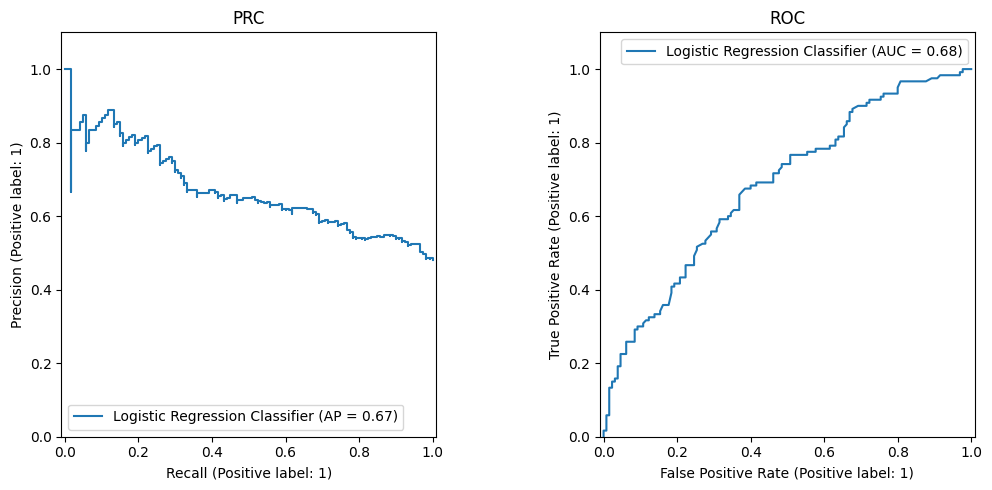

In [45]:
from sklearn.preprocessing import OneHotEncoder

cumulative_time = 0
start_time = time.time()

# Initialize the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the data
X_train_OH = encoder.fit_transform(X_train)
X_test_OH = encoder.fit_transform(X_test)

parameters = {'C': np.linspace(0.1, 3, 20)} # typical grid 

logist = LogisticRegression() # function
logist = GridSearchCV(logist, parameters, cv=5, verbose=0, scoring='average_precision')
logist.fit(X_train_OH, y_train)

best_C_log = logist.best_params_['C']
print(f'Optimal C: {round(best_C_log, 3)}')

logist_best_C = LogisticRegression(C=best_C_log)
logist_best_C.fit(X_train_OH, y_train)
y_scores_log = logist_best_C.decision_function(X_test_OH)

depict_pr_roc(y_test, y_scores_log, 'Logistic Regression Classifier')

cumulative_time += time.time() - start_time
print(f"Total time: {cumulative_time:.4f} seconds")

In [46]:
df_metrics.loc['One-Hot Encoder'] = [
      average_precision_score(y_test, y_scores_log),
    roc_auc_score(y_test, y_scores_log),
    cumulative_time
]
df_metrics

,auc_pr,roc_auc_score,time (sec)
OrdinalEncoder,0.594869,0.600801,0.377771
One-Hot Encoder,0.670817,0.683750,0.438131


_AUC-PR is now a higher (0.6708 > 0.5949; ROC-AUC is also better), while time is much worse (0.5439 seconds > 0.3645 seconds). Overall, for our model specification and quality metrics One-How encoder is better, but is more computational heavy._

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [47]:
df_2.head(3)

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,-1
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,-1
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,-1


Optimal C: 0.1
Logistic Regression Classifier metrics
AUC-PR: 0.6820
AUC-ROC: 0.6794
Total time: 0.4298 seconds


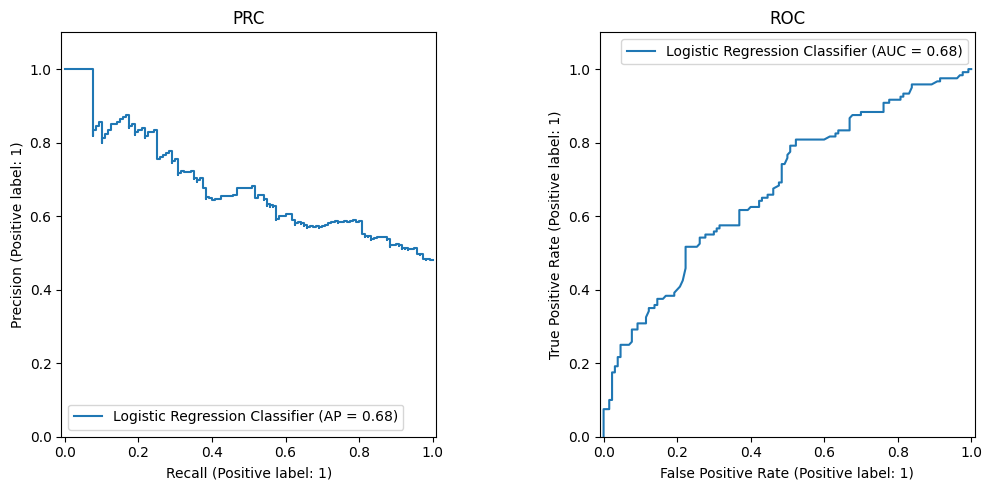

In [48]:
cumulative_time = 0
start_time = time.time()

X_train_MT = X_train.copy()
X_test_MT = X_test.copy()

# Mean-target encode each categorical column
for col in X_train.columns:
    # Compute mean-target encoding on the training data
    mean_encoding = X_train[[col]].join(y_train).groupby(col)['Purchased Bike'].mean()

    # Replace values with mean-target encoding
    X_train_MT[col] = X_train[col].map(mean_encoding)
    X_test_MT[col] = X_test[col].map(mean_encoding)
    
# train hyper-parameter C
parameters = {'C': np.linspace(0.1, 3, 20)} # typical grid 

logist = LogisticRegression() # function
logist = GridSearchCV(logist, parameters, cv=5, verbose=0, scoring='average_precision')
logist.fit(X_train_MT, y_train)

best_C_log = logist.best_params_['C']
print(f'Optimal C: {round(best_C_log, 3)}')

logist_best_C = LogisticRegression(C=best_C_log)
logist_best_C.fit(X_train_MT, y_train)
y_scores_log = logist_best_C.decision_function(X_test_MT)

depict_pr_roc(y_test, y_scores_log, 'Logistic Regression Classifier')

cumulative_time += time.time() - start_time
print(f"Total time: {cumulative_time:.4f} seconds")

In [49]:
df_metrics.loc['Mean-target Encoder'] = [
      average_precision_score(y_test, y_scores_log),
    roc_auc_score(y_test, y_scores_log),
    cumulative_time
]
df_metrics

,auc_pr,roc_auc_score,time (sec)
OrdinalEncoder,0.594869,0.600801,0.377771
One-Hot Encoder,0.670817,0.683750,0.438131
Mean-target Encoder,0.681973,0.679391,0.429829


_Well, it doesn't perform better neigther in calculation time, nor in AUC-PR._

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [50]:
# your code here
# okay, classes we do)

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

class MT_noise(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        """
        Parameters:
        - categorical_columns: list of str, names of the categorical columns to encode
        """
        self.categorical_columns = categorical_columns
        self.counted = {}  # Dictionary to store mean-target encoding for each feature
        self.best_C = None  # Best hyperparameter C for logistic regression
        self.model = None  # Trained logistic regression

    def fit(self, X, y):
        """
        Compute mean-target encodings.
        
        Parameters:
        - X: pd.DataFrame, feature matrix
        - y: pd.Series or np.array, target variable
        """
        X = pd.DataFrame(X)
        y = pd.Series(y)

        # Compute mean-target encoding for each categorical column
        for col in self.categorical_columns:
            self.counted[col] = X[[col]].join(y.rename("target")).groupby(col)["target"].mean()
        return self

    def transform(self, X, eps=1.0):
        """
        Transform the input data by replacing categorical columns with mean-target encoding
        and adding noise proportional to the standard deviation.
        
        Parameters:
        - X: pd.DataFrame, feature matrix
        - eps: float, noise scaling parameter
        """
        X = pd.DataFrame(X).copy()

        for col in self.categorical_columns:
            # Map mean-target encoding for the column
            encoded = X[col].map(self.counted[col]) # see the variables in the initiator
            std = encoded.std()  # STD of the encoded values
            
            # Add random noise proportional to std
            noise = np.random.uniform(-std, std, size=X.shape[0]) / eps
            X[col] = encoded + noise
        
        return X

    def train_logistic(self, X, y):
        """
        Train a logistic regression model.
        
        Parameters:
        - X: pd.DataFrame, feature matrix (already transformed)
        - y: pd.Series or np.array, target variable
        
        Returns:
        - self
        """
        # Define hyperparameter grid
        parameters = {'C': np.linspace(0.1, 3, 20)}
        
        # Initialize logistic regression and grid search
        logist = LogisticRegression()
        grid_search = GridSearchCV(logist, parameters, cv=5, verbose=0, scoring='average_precision')
        
        # Fit the model with grid search
        grid_search.fit(X, y)
        self.best_C = grid_search.best_params_['C']
        print(f'Optimal C: {round(self.best_C, 3)}')
        
        # Train the logistic regression with the best C
        self.model = LogisticRegression(C=self.best_C)
        self.model.fit(X, y)
        
        return self

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

In [52]:
cumulative_time = 0
start_time = time.time()

# Initialize the transformer
noise_adder = MT_noise(categorical_columns=X_train.columns)

# Fit the transformer
noise_adder.fit(X_train, y_train)

# Transform
X_train_transformed = noise_adder.transform(X_train, eps=0.5)
X_test_transformed = noise_adder.transform(X_test, eps=0.5)

# Train logistic regression with hyperparameter optimization
noise_adder.train_logistic(X_train_transformed, y_train)

# Predict probabilities for the test data
y_pred_proba = noise_adder.predict(X_test_transformed)

# Compare with previously estimated models
cumulative_time += time.time() - start_time

df_metrics.loc['Noisy Mean-target Encoder'] = [
      average_precision_score(y_test, y_pred_proba),
    roc_auc_score(y_test, y_pred_proba),
    cumulative_time
]
df_metrics

Optimal C: 0.711


,auc_pr,roc_auc_score,time (sec)
OrdinalEncoder,0.594869,0.600801,0.377771
One-Hot Encoder,0.670817,0.683750,0.438131
Mean-target Encoder,0.681973,0.679391,0.429829
Noisy Mean-target Encoder,0.652528,0.667885,0.377860


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Well, using class structure helped to reduce time, but quality only dropped. I guess, noise only make prediction harder in our case.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [53]:
class Add_noise_estimate(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        """
        Parameters:
        - categorical_columns: list of str, names of the categorical columns to add noise
        """
        self.categorical_columns = categorical_columns
        self.best_C = None  # Best hyperparameter C for logistic regression
        self.model = None  # Trained logistic regression

    def transform(self, X, eps=1.0):
        """
        Add noise to already transformed input data.
        """
        X = pd.DataFrame(X).copy()

        for col in self.categorical_columns:
            std = X[col].std()  # STD of the column values
            noise = np.random.uniform(-std, std, size=X.shape[0]) / eps  # Generate noise
            X[col] = X[col] + noise  # Add noise to the column
        
        return X

    def train_logistic(self, X, y):
        """
        Train a logistic regression model.
        
        Parameters:
        - X: pd.DataFrame, feature matrix (already transformed and noise added)
        - y: pd.Series or np.array, target variable
        
        Returns:
        - self
        """
        parameters = {'C': np.linspace(0.1, 3, 20)}
        
        # Initialize logistic regression and grid search
        logist = LogisticRegression()
        grid_search = GridSearchCV(logist, parameters, cv=5, verbose=0, scoring='average_precision')
        
        # Fit the model with grid search
        grid_search.fit(X, y)
        self.best_C = grid_search.best_params_['C']
        print(f'Optimal C: {round(self.best_C, 3)}')
        
        # Train the logistic regression with the best C
        self.model = LogisticRegression(C=self.best_C)
        self.model.fit(X, y)
        
        return self

    def predict(self, X):
        """
        Predict probabilitie
        
        Parameters:
        - X: pd.DataFrame, feature matrix (already transformed and noise added)
        
        Returns:
        - y_pred_proba: np.array, predicted probabilities
        """
        return self.model.predict_proba(X)[:, 1]


In [54]:
class CumulativeMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns

    def fit(self, X, y):
        """
        Fit the encoder by computing cumulative statistics for each categorical column.
        
        Parameters:
        - X: pd.DataFrame, feature matrix
        - y: pd.Series or np.array, target variable
        
        Returns:
        - self
        """
        X = pd.DataFrame(X).copy()
        y = pd.Series(y)
        self.cumulative_stats = {}

        for col in self.categorical_columns:
            running_sums = {}
            running_counts = {}
            cumulative_means = []

            for index, category in enumerate(X[col]):
                if category not in running_sums:
                    running_sums[category] = 0
                    running_counts[category] = 0

                # Store the cumulative mean
                if running_counts[category] > 0:
                    cumulative_mean = running_sums[category] / running_counts[category]
                else:
                    cumulative_mean = np.nan
                cumulative_means.append(cumulative_mean)

                # Update running sums and counts
                running_sums[category] += y.iloc[index]
                running_counts[category] += 1

            self.cumulative_stats[col] = {
                'running_sums': running_sums,
                'running_counts': running_counts
            }

        return self

    def transform(self, X):
        """
        Transform the input data using the fitted cumulative mean-target encodings.
        
        Parameters:
        - X: pd.DataFrame, feature matrix
        
        Returns:
        - X_transformed: pd.DataFrame, transformed feature matrix
        """
        X = pd.DataFrame(X).copy()

        for col in self.categorical_columns:
            if col not in self.cumulative_stats:
                raise ValueError(f"Column '{col}' was not fitted.")

            running_sums = self.cumulative_stats[col]['running_sums']
            running_counts = self.cumulative_stats[col]['running_counts']
            cumulative_means = []

            for category in X[col]:
                if category in running_sums and running_counts[category] > 0:
                    cumulative_mean = running_sums[category] / running_counts[category]
                else:
                    cumulative_mean = np.nan
                cumulative_means.append(cumulative_mean)

            X[col] = cumulative_means

        return X

In [55]:
cumulative_time = 0
start_time = time.time()

# Step 1: Calculate Cumulative Mean-Target Encoding
cmte = CumulativeMeanTargetEncoder(categorical_columns=X_train.columns)
cmte.fit(X_train, y_train)
X_train_transformed = cmte.transform(X_train)
X_test_transformed = cmte.transform(X_test)

# Step 2: Add Noise and Train Logistic Regression
noise_adder = Add_noise_estimate(categorical_columns=X_train.columns)
X_train_noisy = noise_adder.transform(X_train_transformed, eps=1.0)
noise_adder.train_logistic(X_train_noisy, y_train)

# Step 3: Predict
X_test_noisy = noise_adder.transform(X_test_transformed, eps=1.0)
y_pred_proba = noise_adder.predict(X_test_noisy)

# Compare with previously estimated models
cumulative_time += time.time() - start_time

df_metrics.loc['CM Noisy Mean-target Encoder'] = [
      average_precision_score(y_test, y_pred_proba),
    roc_auc_score(y_test, y_pred_proba),
    cumulative_time
]
df_metrics

Optimal C: 1.474


,auc_pr,roc_auc_score,time (sec)
OrdinalEncoder,0.594869,0.600801,0.377771
One-Hot Encoder,0.670817,0.683750,0.438131
Mean-target Encoder,0.681973,0.679391,0.429829
Noisy Mean-target Encoder,0.652528,0.667885,0.377860
CM Noisy Mean-target Encoder,0.626400,0.662179,0.410083


Well, that's deffinitely an inprovement (still worse than simple Mean-target Encoder)

In [56]:
# Folder Mean Target Encoder

from sklearn.model_selection import KFold

class FoldMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, n_folds=5, random_state=None):
        self.categorical_columns = categorical_columns
        self.n_folds = n_folds
        self.random_state = random_state
        self.global_mean = None

    def fit(self, X, y):
        # Compute the global mean of the target variable
        self.global_mean = np.mean(y)
        return self

    def transform(self, X, y=None):
        if y is None:
            raise ValueError("Target variable `y` is required for transform during training.")

        X = pd.DataFrame(X).copy()
        y = pd.Series(y)
        X_transformed = X.copy()
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        for col in self.categorical_columns:
            encoded_values = np.zeros(X.shape[0])

            for train_idx, val_idx in kf.split(X):
                # Calculate mean-target encoding for the training fold
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train = y.iloc[train_idx]
                fold_means = X_train[[col]].join(y_train.rename("target")).groupby(col)["target"].mean()

                # Apply fold means to the validation fold
                encoded_values[val_idx] = X_val[col].map(fold_means)

            # Handle missing categories by replacing NaN with global mean
            encoded_values = np.where(pd.isnull(encoded_values), self.global_mean, encoded_values)
            X_transformed[col] = encoded_values

        return X_transformed

In [57]:
cumulative_time = 0
start_time = time.time()

# Initialize the transformers
noise_adder = Add_noise_estimate(categorical_columns=X_train.columns)  # Noise adder
FMTE = FoldMeanTargetEncoder(categorical_columns=X_train.columns)  # Fold Mean Target Encoder

# Fit the transformers
FMTE.fit(X_train, y_train)  # Fit Fold Mean Target Encoder

X_train_transformed = FMTE.transform(X_train, y_train)  # Mean-target encode training set
X_train_transformed = noise_adder.transform(X_train_transformed, eps=0.5)  # Add noise

X_test_transformed = FMTE.transform(X_test, y_test)  # Mean-target encode testing set
X_test_transformed = noise_adder.transform(X_test_transformed, eps=0.5)  # Add noise

# Train logistic regression
noise_adder.train_logistic(X_train_transformed, y_train)

# Predict probabilities for the test data
y_pred_proba = noise_adder.predict(X_test_transformed)

# Compare with previously estimated models
cumulative_time += time.time() - start_time

df_metrics.loc['FM Noisy Mean-target Encoder'] = [
      average_precision_score(y_test, y_pred_proba),
    roc_auc_score(y_test, y_pred_proba),
    cumulative_time
]
df_metrics

Optimal C: 1.321


,auc_pr,roc_auc_score,time (sec)
OrdinalEncoder,0.594869,0.600801,0.377771
One-Hot Encoder,0.670817,0.683750,0.438131
Mean-target Encoder,0.681973,0.679391,0.429829
Noisy Mean-target Encoder,0.652528,0.667885,0.377860
CM Noisy Mean-target Encoder,0.626400,0.662179,0.410083
FM Noisy Mean-target Encoder,0.489550,0.477756,0.519669


Well, these methods are fun, but sometimes just the easiest model is the correct one))

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \cdot \text{global\_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$

где $\text{global\_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [58]:
class SmoothedMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, smoothing_factor=None, global_mean=None):
        """
        Initialize the encoder.
        
        Parameters:
        - categorical_columns: list of str
        - smoothing_factor: float
        - global_mean: float or None
        """
        self.categorical_columns = categorical_columns
        self.smoothing_factor = smoothing_factor
        self.global_mean = global_mean
        self.mean_encoding = {} 

    def fit(self, X, y, global_mean=None):
        """
        Fit the encoder
        
        Parameters:
        - X: pd.DataFrame, feature matrix
        - y: pd.Series or np.array
        - global_mean: float or None
        
        Returns:
        - self
        """
        X = pd.DataFrame(X).copy()
        y = pd.Series(y)

        self.global_mean = y.mean()
        
        # Allow to override C during training
        if self.smoothing_factor is None:
        # Default if smoothing factor if not provided
            self.smoothing_factor = 10

        # Calculate smoothed mean-target encodings
        for col in self.categorical_columns:
            category_counts = X[col].value_counts()
            category_means = X[[col]].join(y.rename("target")).groupby(col)["target"].mean()
            
            # Compute the smoothed mean
            smoothed = (category_means * category_counts + self.smoothing_factor * self.global_mean) / \
                       (category_counts + self.smoothing_factor)
            
            # Store
            self.mean_encoding[col] = smoothed.to_dict()
        
        return self

    def transform(self, X):
        """
        Transform the input data using the learned encodings.
        
        Parameters:
        - X: pd.DataFrame, feature matrix
        
        Returns:
        - X_transformed
        """
        X = pd.DataFrame(X).copy()

        for col in self.categorical_columns:
            # Map the smoothed encodings to the column
            X[col] = X[col].map(self.mean_encoding[col]).fillna(self.global_mean)
        
        return X

* Mean-target Encoding

In [59]:
# Initialize the transformers
# noise_adder = Add_noise_estimate(categorical_columns=X_train.columns)  # Noise adder
SMTE = SmoothedMeanTargetEncoder(categorical_columns=X_train.columns, )  # Fold Mean Target Encoder

# Fit the transformers
SMTE.fit(X_train, y_train)  # Fit Fold Mean Target Encoder

X_train_transformed = SMTE.transform(X_train)  # Mean-target encode training set

X_test_transformed = SMTE.transform(X_test)  # Mean-target encode testing set

# Train logistic regression
noise_adder.train_logistic(X_train_transformed, y_train)

# Predict probabilities for the test data
y_pred_proba = noise_adder.predict(X_test_transformed)

# Compare with previously estimated models
cumulative_time += time.time() - start_time

df_metrics.loc['SM Mean-target Encoder'] = [
      average_precision_score(y_test, y_pred_proba),
    roc_auc_score(y_test, y_pred_proba),
    cumulative_time
]
df_metrics

Optimal C: 1.321


,auc_pr,roc_auc_score,time (sec)
OrdinalEncoder,0.594869,0.600801,0.377771
One-Hot Encoder,0.670817,0.683750,0.438131
Mean-target Encoder,0.681973,0.679391,0.429829
Noisy Mean-target Encoder,0.652528,0.667885,0.377860
CM Noisy Mean-target Encoder,0.626400,0.662179,0.410083
FM Noisy Mean-target Encoder,0.489550,0.477756,0.519669
SM Mean-target Encoder,0.682676,0.680096,1.459337


* Mean-target Encoding (noise)

In [60]:
cumulative_time = 0
start_time = time.time()

# Initialize the transformers
# noise_adder = Add_noise_estimate(categorical_columns=X_train.columns)  # Noise adder
SMTE = SmoothedMeanTargetEncoder(categorical_columns=X_train.columns)  # Fold Mean Target Encoder

# Fit the transformers
SMTE.fit(X_train, y_train)  # Fit Fold Mean Target Encoder

X_train_transformed = SMTE.transform(X_train)  # Mean-target encode training set
X_train_transformed = noise_adder.transform(X_train_transformed, eps=0.5)  # Add noise

X_test_transformed = SMTE.transform(X_test)  # Mean-target encode testing set
X_test_transformed = noise_adder.transform(X_test_transformed, eps=0.5)  # Add noise

# Train logistic regression
noise_adder.train_logistic(X_train_transformed, y_train)

# Predict probabilities for the test data
y_pred_proba = noise_adder.predict(X_test_transformed)

# Compare with previously estimated models
cumulative_time += time.time() - start_time

df_metrics.loc['SM Noisy Mean-target Encoder'] = [
      average_precision_score(y_test, y_pred_proba),
    roc_auc_score(y_test, y_pred_proba),
    cumulative_time
]
df_metrics

Optimal C: 0.1


,auc_pr,roc_auc_score,time (sec)
OrdinalEncoder,0.594869,0.600801,0.377771
One-Hot Encoder,0.670817,0.683750,0.438131
Mean-target Encoder,0.681973,0.679391,0.429829
Noisy Mean-target Encoder,0.652528,0.667885,0.377860
CM Noisy Mean-target Encoder,0.626400,0.662179,0.410083
FM Noisy Mean-target Encoder,0.489550,0.477756,0.519669
SM Mean-target Encoder,0.682676,0.680096,1.459337
SM Noisy Mean-target Encoder,0.572821,0.588590,0.470952


Now try to train C

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, roc_auc_score

In [62]:
cumulative_time = 0
start_time = time.time()

# pipeline
pipeline = Pipeline([
    ('encoder', SmoothedMeanTargetEncoder(categorical_columns=X_train.columns)),
    ('classifier', LogisticRegression())
])

# Parameter grid for smoothing_factor and logistic regression C
param_grid = {
    'encoder__smoothing_factor': np.linspace(0.1, 3, 20),  # Range of smoothing factors to try
    'classifier__C': np.logspace(-2, 2, 5)  # Regularization parameter for logistic regression
}

# grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='average_precision',
    verbose=1
)

# Fit grid search
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best (C): {best_params['encoder__smoothing_factor']}")
print(f"Best Average Precision: {best_score:.4f}")
print(f"Grid Search Time: {end_time - start_time:.2f} seconds")

# # Evaluate on test set
# best_pipeline = grid_search.best_estimator_
# X_test_transformed = best_pipeline['encoder'].transform(X_test)
# y_pred_proba = best_pipeline['classifier'].predict_proba(X_test_transformed)[:, 1]

# roc_auc = roc_auc_score(y_test, y_pred_proba)
# avg_precision = average_precision_score(y_test, y_pred_proba)

# print(f"ROC AUC on Test Set: {roc_auc:.4f}")
# print(f"Average Precision on Test Set: {avg_precision:.4f}")
cumulative_time += time.time() - start_time

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best (C): 2.8473684210526318
Best Average Precision: 0.5953
Grid Search Time: 9.79 seconds


Now do the model for optimal C

In [63]:
start_time = time.time()

# Initialize the transformer
SMTE = SmoothedMeanTargetEncoder(categorical_columns=X_train.columns)  # Fold Mean Target Encoder

## OPTIMAL C

SMTE.smoothing_factor = best_params['encoder__smoothing_factor']

# Fit the transformers
SMTE.fit(X_train, y_train)  # Fit Fold Mean Target Encoder

X_train_transformed = SMTE.transform(X_train)  # Mean-target encode training set
# X_train_transformed = noise_adder.transform(X_train_transformed, eps=0.5)  # Add noise

X_test_transformed = SMTE.transform(X_test)  # Mean-target encode testing set
# X_test_transformed = noise_adder.transform(X_test_transformed, eps=0.5)  # Add noise

# Train logistic regression
noise_adder.train_logistic(X_train_transformed, y_train)

# Predict probabilities for the test data
y_pred_proba = noise_adder.predict(X_test_transformed)

# Compare with previously estimated models
cumulative_time += time.time() - start_time

df_metrics.loc['SM Mean-target Encoder, C*'] = [
      average_precision_score(y_test, y_pred_proba),
    roc_auc_score(y_test, y_pred_proba),
    cumulative_time
]
df_metrics

Optimal C: 1.016


,auc_pr,roc_auc_score,time (sec)
OrdinalEncoder,0.594869,0.600801,0.377771
One-Hot Encoder,0.670817,0.683750,0.438131
Mean-target Encoder,0.681973,0.679391,0.429829
Noisy Mean-target Encoder,0.652528,0.667885,0.377860
CM Noisy Mean-target Encoder,0.626400,0.662179,0.410083
FM Noisy Mean-target Encoder,0.489550,0.477756,0.519669
SM Mean-target Encoder,0.682676,0.680096,1.459337
SM Noisy Mean-target Encoder,0.572821,0.588590,0.470952
"SM Mean-target Encoder, C*",0.682754,0.680737,10.175133


Well, look at it - already better than usual One-Hot Encoder)

In [64]:
print(f"SM Mean-target Encoder, C* better than 	One-Hot Encoder by {df_metrics.loc['SM Mean-target Encoder, C*', 'auc_pr'] - df_metrics.loc['One-Hot Encoder', 'auc_pr']}")

SM Mean-target Encoder, C* better than 	One-Hot Encoder by 0.01193746999630052


In [65]:
start_time = time.time()

# Initialize the transformers
# noise_adder = Add_noise_estimate(categorical_columns=X_train.columns)  # Noise adder
SMTE = SmoothedMeanTargetEncoder(categorical_columns=X_train.columns)  # Fold Mean Target Encoder

## OPTIMAL C

SMTE.smoothing_factor = best_params['encoder__smoothing_factor']

# Fit the transformers
SMTE.fit(X_train, y_train)  # Fit Fold Mean Target Encoder

X_train_transformed = SMTE.transform(X_train)  # Mean-target encode training set
X_train_transformed = noise_adder.transform(X_train_transformed, eps=0.5)  # Add noise

X_test_transformed = SMTE.transform(X_test)  # Mean-target encode testing set
X_test_transformed = noise_adder.transform(X_test_transformed, eps=0.5)  # Add noise

# Train logistic regression
noise_adder.train_logistic(X_train_transformed, y_train)

# Predict probabilities for the test data
y_pred_proba = noise_adder.predict(X_test_transformed)

# Compare with previously estimated models
cumulative_time += time.time() - start_time

df_metrics.loc['SM Noisy Mean-target Encoder, C*'] = [
      average_precision_score(y_test, y_pred_proba),
    roc_auc_score(y_test, y_pred_proba),
    cumulative_time
]
df_metrics

Optimal C: 1.016


,auc_pr,roc_auc_score,time (sec)
OrdinalEncoder,0.594869,0.600801,0.377771
One-Hot Encoder,0.670817,0.683750,0.438131
Mean-target Encoder,0.681973,0.679391,0.429829
Noisy Mean-target Encoder,0.652528,0.667885,0.377860
CM Noisy Mean-target Encoder,0.626400,0.662179,0.410083
FM Noisy Mean-target Encoder,0.489550,0.477756,0.519669
SM Mean-target Encoder,0.682676,0.680096,1.459337
SM Noisy Mean-target Encoder,0.572821,0.588590,0.470952
"SM Mean-target Encoder, C*",0.682754,0.680737,10.175133
"SM Noisy Mean-target Encoder, C*",0.553265,0.594103,10.578006


Noise wasn't useful again.

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных

_I believe that mean is better for our problem - it is more representative for variables with low variance and, as we will see from desctiptive statistics, STD is not that high, compared to mean values._

In [66]:
X_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ID        1000 non-null   int64
 1   Income    1000 non-null   int64
 2   Children  1000 non-null   int64
 3   Cars      1000 non-null   int64
 4   Age       1000 non-null   int64
dtypes: int64(5)
memory usage: 39.2 KB


In [67]:
X_numerical.describe()

,ID,Income,Children,Cars,Age
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,19965.992000,56140.000000,1.908000,1.452000,44.190000
std,5347.333948,31081.609779,1.626094,1.124705,11.353537
min,11000.000000,10000.000000,0.000000,0.000000,25.000000
25%,15290.750000,30000.000000,0.000000,1.000000,35.000000
50%,19744.000000,60000.000000,2.000000,1.000000,43.000000
75%,24470.750000,70000.000000,3.000000,2.000000,52.000000
max,29447.000000,170000.000000,5.000000,4.000000,89.000000


In [68]:
print(X_categorical.shape)
print(X_numerical.shape)
print(X.shape)

(1000, 7)
(1000, 5)
(1000, 12)


Well, income variable definitely has outliers, as well as children, cars and age. Basically, let's do simple outline selection.

In [69]:
# drop outliers- simple and easy
sample_refined= df_2.copy()
for col in X_numerical.columns:
    q_99 = sample_refined[col].quantile(0.99) # calculate q99 - not willing to sacrifice many obs - there are only 1000 of them
    sample_refined = sample_refined[sample_refined[col] < q_99] # select all rows with values less than it 

In [70]:
print(f"1% outliers deleted: {df_2.shape[0] - sample_refined.shape[0]}")

1% outliers deleted: 153


In [71]:
# Отделим X и y
y = sample_refined['Purchased Bike']
X = sample_refined.drop(columns=['Purchased Bike'])


# now 666!) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666, stratify=y)

In [72]:
X_train.columns

Index(['ID', 'Marital Status', 'Gender', 'Income', 'Children', 'Education',
       'Occupation', 'Home Owner', 'Cars', 'Commute Distance', 'Region',
       'Age'],
      dtype='object')

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [73]:
# unique values
for col in X_numerical.drop(columns=['ID']):
    unique_values = X_numerical[col].unique()
    print(f"Column '{col}': {len(unique_values)}")

Column 'Income': 16
Column 'Children': 6
Column 'Cars': 5
Column 'Age': 53


_Not that much - only age differes a lot_

In [74]:
df_metrics.sort_values(by='auc_pr', ascending=False)

,auc_pr,roc_auc_score,time (sec)
"SM Mean-target Encoder, C*",0.682754,0.680737,10.175133
SM Mean-target Encoder,0.682676,0.680096,1.459337
Mean-target Encoder,0.681973,0.679391,0.429829
One-Hot Encoder,0.670817,0.683750,0.438131
Noisy Mean-target Encoder,0.652528,0.667885,0.377860
CM Noisy Mean-target Encoder,0.626400,0.662179,0.410083
OrdinalEncoder,0.594869,0.600801,0.377771
SM Noisy Mean-target Encoder,0.572821,0.588590,0.470952
"SM Noisy Mean-target Encoder, C*",0.553265,0.594103,10.578006
FM Noisy Mean-target Encoder,0.489550,0.477756,0.519669


Well, so far SM Mean-target Encoder, C* is the best, judging by auc_pr. Let's inplement it for our updated dataset. Given that we use classes, it should not be that hard.

In [75]:
X_categorical.columns

Index(['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner',
       'Commute Distance', 'Region'],
      dtype='object')

In [76]:
start_time = time.time()

# Initialize the transformer
SMTE = SmoothedMeanTargetEncoder(categorical_columns=X_categorical.columns)

## OPTIMAL C

SMTE.smoothing_factor = best_params['encoder__smoothing_factor']

# Fit the transformers
SMTE.fit(X_train, y_train)  # Fit Fold Mean Target Encoder

X_train_transformed = SMTE.transform(X_train)  # Mean-target encode training set
# X_train_transformed = noise_adder.transform(X_train_transformed, eps=0.5)  # Add noise

X_test_transformed = SMTE.transform(X_test)  # Mean-target encode testing set
# X_test_transformed = noise_adder.transform(X_test_transformed, eps=0.5)  # Add noise

# Train logistic regression
noise_adder.train_logistic(X_train_transformed, y_train)

# Predict probabilities for the test data
y_pred_proba = noise_adder.predict(X_test_transformed)

# Compare with previously estimated models
cumulative_time += time.time() - start_time

df_metrics.loc['SM Mean-target Encoder, C*, int'] = [
      average_precision_score(y_test, y_pred_proba),
    roc_auc_score(y_test, y_pred_proba),
    cumulative_time
]
df_metrics

Optimal C: 3.0


,auc_pr,roc_auc_score,time (sec)
OrdinalEncoder,0.594869,0.600801,0.377771
One-Hot Encoder,0.670817,0.683750,0.438131
Mean-target Encoder,0.681973,0.679391,0.429829
Noisy Mean-target Encoder,0.652528,0.667885,0.377860
CM Noisy Mean-target Encoder,0.626400,0.662179,0.410083
FM Noisy Mean-target Encoder,0.489550,0.477756,0.519669
SM Mean-target Encoder,0.682676,0.680096,1.459337
SM Noisy Mean-target Encoder,0.572821,0.588590,0.470952
"SM Mean-target Encoder, C*",0.682754,0.680737,10.175133
"SM Noisy Mean-target Encoder, C*",0.553265,0.594103,10.578006


SM Mean-target Encoder, C*, int metrics
AUC-PR: 0.7031
AUC-ROC: 0.7252


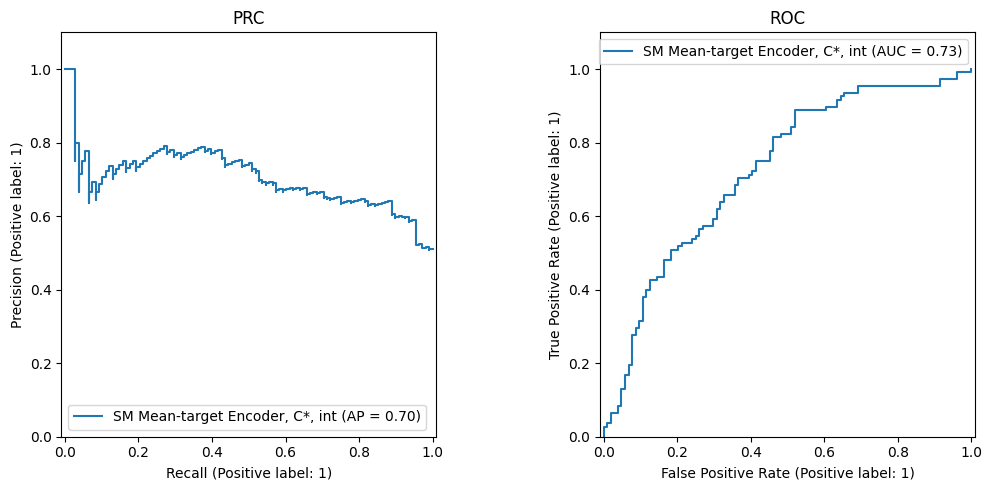

In [77]:
depict_pr_roc(y_test, y_pred_proba, 'SM Mean-target Encoder, C*, int')

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

_Well, it's the best model so far. In my case- extra int variables paid off._



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 
1) Do not increase the number of features
2) Directly related to the target

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [78]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
# again doesn't work => manual download

In [79]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df_3 = \
pd.read_csv('C:/Users/Popov/Documents/Studies/NES_studies/Python/Machine_Learning/HA/HA_3/adult.data',\
            header=None, names=columns)
df_3['income'] = (df_3['income'] != " <=50K").astype('int32')
df_3.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
32270,60,Private,127084,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,2042,34,United-States,0
30006,43,State-gov,24763,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1887,45,United-States,1
6189,32,State-gov,443546,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,45,United-States,0
390,35,Private,220098,HS-grad,9,Married-civ-spouse,Other-service,Wife,White,Female,0,0,40,United-States,1
9555,21,Self-emp-not-inc,409230,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,30,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [80]:
# Отделим X и y
y = df_3['income']

X = df_3.drop(columns=['income'])
column_list = X.columns
# has to do it now, otherwise dimenstions of X_test, X_train might not coincide (# uniques values in each columns differ)
encoder = OneHotEncoder(sparse_output = False)
X_HO = encoder.fit_transform(X.select_dtypes(include=['object']))
print(f"New encoded variables: {X_HO.shape[1] - len(X.columns)}")
# now 666!) 
X_train, X_test, y_train, y_test = train_test_split(X_HO, y, test_size=0.25, random_state=777, stratify=y)
# If stratify=y, the train and test sets will have the same class proportions as in the original dataset.


New encoded variables: 88


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

88 - already done

In [81]:
print(X_train.shape)
print(X_test.shape)

(24420, 102)
(8141, 102)


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [82]:
cumulative_time = 0
start_time = time.time()

parameters = {'C': np.linspace(0.1, 3, 20)} # typical grid 

logist = LogisticRegression() # function
logist = GridSearchCV(logist, parameters, cv=5, verbose=0, scoring='average_precision')
logist.fit(X_train, y_train)

best_C_log = logist.best_params_['C']
print(f'Optimal C: {round(best_C_log, 3)}')

logist_best_C = LogisticRegression(C=best_C_log)
logist_best_C.fit(X_train, y_train)
y_scores_log = logist_best_C.decision_function(X_test)

# Compare with previously estimated models
cumulative_time += time.time() - start_time

Optimal C: 0.558


In [83]:
df_metrics_2 = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'time (sec)']
)
precision, recall, _ = precision_recall_curve(y_test, y_scores_log)
# добавление очередной строки с характеристиками метода
df_metrics_2.loc['All OH variables'] = [
      average_precision_score(y_test, y_scores_log),
      roc_auc_score(y_test, y_scores_log),
    cumulative_time
]
df_metrics_2

,auc_pr,roc_auc_score,time (sec)
All OH variables,0.686578,0.881459,8.493692


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

_Nice. All that time I was using pre-training of hyperparameter; however, with logistic function overfit is a bit hard to achieve; so, I hope, it's okay, especially given that I used cross-validation for that_

In [84]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=777
)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [85]:
X_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [86]:
column_names = encoder.get_feature_names_out(X.select_dtypes(include=['object']).columns)
# Convert NumPy array to DataFrame
X_HO_df = pd.DataFrame(X_HO, columns=column_names)

In [87]:
features= pd.DataFrame({'feature': X_HO_df.columns, 'importance': abs(logist_best_C.coef_[0])})
keep_f = features.sort_values('importance', ascending=False).head(40)['feature']
keep_f

19                     education_ Doctorate
23                   education_ Prof-school
21                       education_ Masters
50                  relationship_ Own-child
29            marital-status_ Never-married
14                       education_ 7th-8th
27       marital-status_ Married-civ-spouse
15                           education_ 9th
41              occupation_ Priv-house-serv
64                 native-country_ Columbia
12                       education_ 1st-4th
26        marital-status_ Married-AF-spouse
10                          education_ 11th
9                           education_ 10th
58                              sex_ Female
52                       relationship_ Wife
36              occupation_ Exec-managerial
40                occupation_ Other-service
62                   native-country_ Canada
13                       education_ 5th-6th
30                marital-status_ Separated
82                    native-country_ Italy
18                     education

In [88]:
X_HO_df = X_HO_df[keep_f]
X_HO_df.columns

Index(['education_ Doctorate', 'education_ Prof-school', 'education_ Masters',
       'relationship_ Own-child', 'marital-status_ Never-married',
       'education_ 7th-8th', 'marital-status_ Married-civ-spouse',
       'education_ 9th', 'occupation_ Priv-house-serv',
       'native-country_ Columbia', 'education_ 1st-4th',
       'marital-status_ Married-AF-spouse', 'education_ 11th',
       'education_ 10th', 'sex_ Female', 'relationship_ Wife',
       'occupation_ Exec-managerial', 'occupation_ Other-service',
       'native-country_ Canada', 'education_ 5th-6th',
       'marital-status_ Separated', 'native-country_ Italy',
       'education_ Bachelors', 'occupation_ Farming-fishing',
       'native-country_ Germany', 'education_ Preschool',
       'native-country_ France', 'relationship_ Other-relative',
       'native-country_ Cambodia', 'marital-status_ Married-spouse-absent',
       'occupation_ Handlers-cleaners', 'native-country_ Dominican-Republic',
       'occupation_ Protec

In [89]:
X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(X_HO_df, y, test_size=0.25, random_state=777, stratify=y)

X_train_split_40, X_val_40, y_train_split_40, y_val_40 = train_test_split(
    X_train_40, y_train_40, test_size=0.3, random_state=777
)

In [90]:
cumulative_time = 0
start_time = time.time()

parameters = {'C': np.linspace(0.1, 3, 20)} # typical grid 

logist = LogisticRegression() # function
logist = GridSearchCV(logist, parameters, cv=5, verbose=0, scoring='average_precision')
logist.fit(X_train_split_40, y_train_split_40)

best_C_log = logist.best_params_['C']
print(f'Optimal C: {round(best_C_log, 3)}')

logist_best_C = LogisticRegression(C=best_C_log)
logist_best_C.fit(X_train_split_40, y_train_split_40)
y_scores_log = logist_best_C.decision_function(X_val_40)

# Compare with previously estimated models
cumulative_time += time.time() - start_time

precision, recall, _ = precision_recall_curve(y_val, y_scores_log)
# добавление очередной строки с характеристиками метода
df_metrics_2.loc['40 OH variables'] = [
      average_precision_score(y_val_40, y_scores_log),
      roc_auc_score(y_val_40, y_scores_log),
    cumulative_time
]
df_metrics_2

Optimal C: 0.711


,auc_pr,roc_auc_score,time (sec)
All OH variables,0.686578,0.881459,8.493692
40 OH variables,0.658704,0.871179,2.951349


Изменилось ли качество? Как?

Well, only in the worse direction; even thouth it takes less time to compute)

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

Scaling

In [91]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit to training data and transform both training and test data
X_HO_s = scaler.fit_transform(X_HO_df)

# Convert NumPy array to DataFrame
X_HO_df_s = pd.DataFrame(X_HO_s, columns=X_HO_df.columns)
X_HO_df_s.head(3)

,education_ Doctorate,education_ Prof-school,education_ Masters,relationship_ Own-child,marital-status_ Never-married,education_ 7th-8th,marital-status_ Married-civ-spouse,education_ 9th,occupation_ Priv-house-serv,native-country_ Columbia,education_ 1st-4th,marital-status_ Married-AF-spouse,education_ 11th,education_ 10th,sex_ Female,relationship_ Wife,occupation_ Exec-managerial,occupation_ Other-service,native-country_ Canada,education_ 5th-6th,marital-status_ Separated,native-country_ Italy,education_ Bachelors,occupation_ Farming-fishing,native-country_ Germany,education_ Preschool,native-country_ France,relationship_ Other-relative,native-country_ Cambodia,marital-status_ Married-spouse-absent,occupation_ Handlers-cleaners,native-country_ Dominican-Republic,occupation_ Protective-serv,occupation_ Prof-specialty,workclass_ Without-pay,occupation_ Tech-support,native-country_ England,race_ Amer-Indian-Eskimo,native-country_ Nicaragua,marital-status_ Divorced
0,-0.113344,-0.134196,-0.236374,-0.429346,1.431058,-0.142272,-0.922841,-0.126645,-0.067802,-0.042606,-0.072016,-0.026587,-0.193487,-0.171753,-0.703071,-0.224927,-0.377746,-0.335541,-0.061073,-0.10165,-0.180285,-0.047402,2.253993,-0.17745,-0.065002,-0.039607,-0.029857,-0.17625,-0.024163,-0.114037,-0.209578,-0.046416,-0.142608,-0.381663,-0.02074,-0.171279,-0.052647,-0.098201,-0.032331,-0.397508
1,-0.113344,-0.134196,-0.236374,-0.429346,-0.698784,-0.142272,1.083611,-0.126645,-0.067802,-0.042606,-0.072016,-0.026587,-0.193487,-0.171753,-0.703071,-0.224927,2.647285,-0.335541,-0.061073,-0.10165,-0.180285,-0.047402,2.253993,-0.17745,-0.065002,-0.039607,-0.029857,-0.17625,-0.024163,-0.114037,-0.209578,-0.046416,-0.142608,-0.381663,-0.02074,-0.171279,-0.052647,-0.098201,-0.032331,-0.397508
2,-0.113344,-0.134196,-0.236374,-0.429346,-0.698784,-0.142272,-0.922841,-0.126645,-0.067802,-0.042606,-0.072016,-0.026587,-0.193487,-0.171753,-0.703071,-0.224927,-0.377746,-0.335541,-0.061073,-0.10165,-0.180285,-0.047402,-0.443657,-0.17745,-0.065002,-0.039607,-0.029857,-0.17625,-0.024163,-0.114037,4.771494,-0.046416,-0.142608,-0.381663,-0.02074,-0.171279,-0.052647,-0.098201,-0.032331,2.515672


In [92]:
X_train_40_s, X_test_40_s, y_train_40_s, y_test_40_s = train_test_split(X_HO_df_s, y, test_size=0.25, random_state=777, stratify=y)

X_train_split_40_s, X_val_40_s, y_train_split_40_s, y_val_40_s = train_test_split(
    X_train_40_s, y_train_40_s, test_size=0.3, random_state=777
)

In [93]:
cumulative_time = 0
start_time = time.time()

parameters = {'C': np.linspace(0.1, 3, 20)} # typical grid 

logist = LogisticRegression() # function
logist = GridSearchCV(logist, parameters, cv=5, verbose=0, scoring='average_precision')
logist.fit(X_train_split_40_s, y_train_split_40_s)

best_C_log = logist.best_params_['C']
print(f'Optimal C: {round(best_C_log, 3)}')

logist_best_C = LogisticRegression(C=best_C_log)
logist_best_C.fit(X_train_split_40_s, y_train_split_40_s)
y_scores_log = logist_best_C.decision_function(X_val_40_s)

# Compare with previously estimated models
cumulative_time += time.time() - start_time

precision, recall, _ = precision_recall_curve(y_val, y_scores_log)
# добавление очередной строки с характеристиками метода
df_metrics_2.loc['40 OH, scaled variables'] = [
      average_precision_score(y_val_40_s, y_scores_log),
      roc_auc_score(y_val_40_s, y_scores_log),
    cumulative_time
]
df_metrics_2

Optimal C: 1.016


,auc_pr,roc_auc_score,time (sec)
All OH variables,0.686578,0.881459,8.493692
40 OH variables,0.658704,0.871179,2.951349
"40 OH, scaled variables",0.658640,0.871397,1.922167


Well, changes are insignificant(

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [94]:
# your code here

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** # your code here

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [95]:
# your code here

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [96]:
# your code here

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [97]:
# your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [98]:
# your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** # your code here

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [99]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

"wget" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.
"unzip" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


FileNotFoundError: [Errno 2] No such file or directory: 'bank-additional/bank-additional-full.csv'

In [ ]:
df.head()

In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [ ]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            # "metric_key": metric_value
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [ ]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [ ]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [ ]:
# your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [ ]:
# your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
# your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [ ]:
# your code here

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [ ]:
# your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [ ]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ # your answer here